In [1]:
import numpy as np
import pandas as pd
import math

from scipy.optimize import minimize, Bounds, fmin_cg
from skopt import gp_minimize
from deap import base, creator, tools, algorithms
import random

from matplotlib import pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_datareader as pdr
import pandas_market_calendars as mcal

import datetime


In [2]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=5400) #15 years analysis
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

#S&P 500 ticker
SnP_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol
Russell_1000_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/Russell_1000_Index')[3].Symbol
SnP600_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[0].Symbol

def final_ticker(T_list):
    return list(set(T_list))

index_banch_mart = ["SPY"]

tickers = final_ticker(SnP_componet_ticker)

def get_stock_data(tickers_list, start_date, end_date):
    
    all_tickers = list(dict.fromkeys(tickers_list))
    
    data = yf.download(all_tickers, start=start_date, end=end_date)['Close']
    if isinstance(data, pd.DataFrame):
        data = data.dropna(axis=1)
        available_tickers = list(data.columns)
    else:
        available_tickers = all_tickers
    
    return data, available_tickers

def initialize_portfolio(tickers, equal_weight=True):
    n_assets = len(tickers)
    if equal_weight:
        weight = 1.0/n_assets
    else:
        weight = 1.0
        
    return {ticker: weight for ticker in tickers}

df,tickers = get_stock_data(tickers,valid_start_day,valid_end_day)

df_BM,_ = get_stock_data(index_banch_mart, valid_start_day,valid_end_day)
number_of_stocks = df.shape[1]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-28 -> 2025-04-10)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


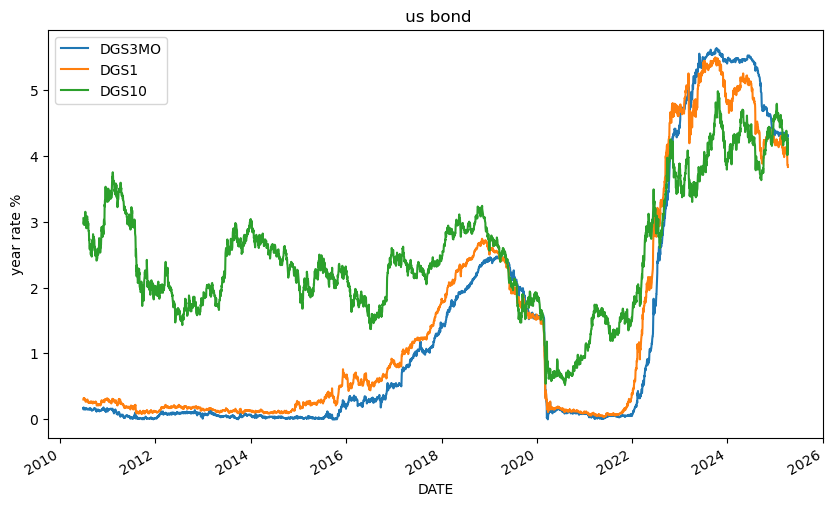

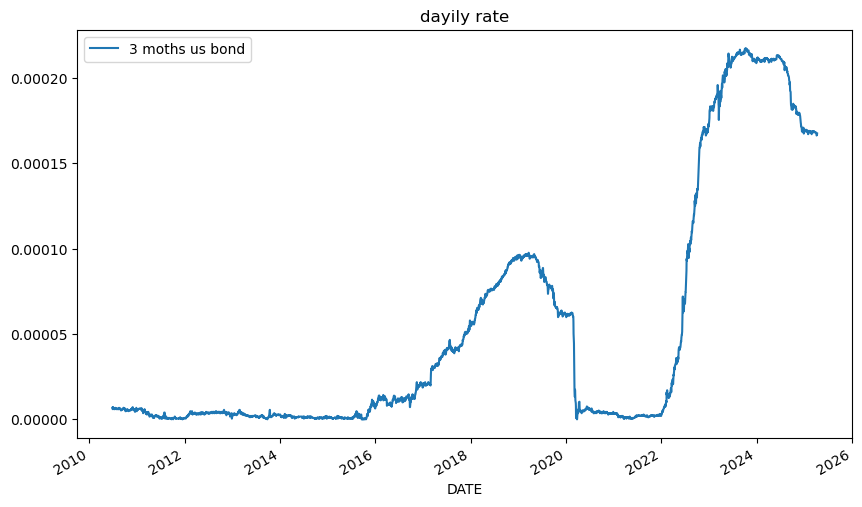

In [3]:
US_TB = ['DGS3MO', 'DGS1', 'DGS10'] #3 months, 1 year, 10 years

df_bonds = pdr.DataReader(US_TB, 'fred', valid_start_day, valid_end_day).dropna()
df_bonds["3month_cts_rate"] = (1+df_bonds["DGS3MO"]/100)**(1/252) -1 
risk_free_rate = df_bonds["3month_cts_rate"]


df_bonds["DGS3MO"].plot(title = " us bond", ylabel="year rate %",figsize=(10, 6))
#df_bonds["3month_cts_rate"].plot()
df_bonds["DGS1"].plot( )
df_bonds["DGS10"].plot( )
plt.legend()
plt.show()

risk_free_rate.plot(label = "3 moths us bond", title="dayily rate",figsize=(10, 6))
#df_bonds["3month_cts_rate"].plot()
plt.legend()
plt.show()

In [4]:
ret_df = np.log(df/df.shift(1)).dropna()
ret_df_BM = np.log(df_BM/df_BM.shift(1)).dropna()

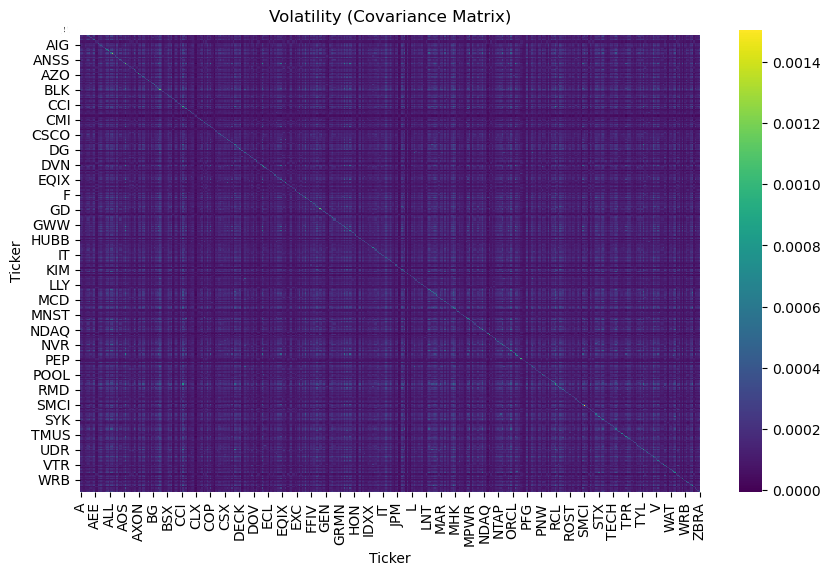

In [5]:
Covarian_matrix = ret_df.cov()
plt.figure(figsize=(10, 6))
sns.heatmap(Covarian_matrix, annot=True, cmap='viridis', fmt='.2e')
plt.title('Volatility (Covariance Matrix)')
plt.show()

Optimization Time

In [7]:
def Sharpe_pf(weight_dict, return_df, risk_free_rate):
    Weight = np.array([weight_dict[col] for col in return_df.columns])
    
    pf_risk = np.sqrt(Weight.dot(return_df.cov().dot(Weight)))
    pf_mean = return_df.mean().dot(Weight)
    
    if type(risk_free_rate) != int:
        risk_free_rate = risk_free_rate.mean()
    return -(pf_mean-risk_free_rate)/pf_risk

def Sortino_pf(weight_dict, return_df, benchmark_df):
    Weight = np.array([weight_dict[col] for col in return_df.columns])
    
    pf_return = return_df.dot(Weight)
    
    if isinstance(benchmark_df, (int, float)):
        benchmark_return = benchmark_df
    else:
        benchmark_return = benchmark_df.mean()
    
    downside_deviation = np.sqrt(
        np.mean(
            np.minimum(0, pf_return - benchmark_return) ** 2
        )
    )
    pf_mean = pf_return.mean()
    
    if downside_deviation == 0:
        return np.inf if pf_mean > benchmark_return else -np.inf
    return -(pf_mean - benchmark_return) / downside_deviation

def Ulcer_pf(weight_dict, return_df, risk_free_rate):
    Weight = np.array([weight_dict[col] for col in return_df.columns])
    
    cumulative_returns = (1 + return_df.dot(Weight)).cumprod()
    max_cumulative_returns = cumulative_returns.cummax()
    
    drawdowns = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns * 100
    
    ulcer_index = np.sqrt(np.mean(drawdowns ** 2))
    
    return ulcer_index


In [14]:
def split_train_test(df, BM, rfr, Fraction):
    def Log_return(df):
        return np.log(df/df.shift(1)).dropna()
    
    # First align all raw data by date
    common_indices = df.index.intersection(BM.index).intersection(rfr.index)
    df = df.loc[common_indices]
    BM = BM.loc[common_indices]
    rfr = rfr.loc[common_indices]
    
    # Calculate log returns
    df_returns = Log_return(df)
    BM_returns = Log_return(BM)
    rfr_log = np.log(1 + rfr)
    
    # Get common dates after calculating returns
    return_indices = df_returns.index.intersection(BM_returns.index)
    df_returns = df_returns.loc[return_indices]
    BM_returns = BM_returns.loc[return_indices]
    rfr_log = rfr_log.loc[return_indices]
    
    # Split into train and test
    matched_len = len(df_returns)
    Train_len = int(matched_len * Fraction)
    
    split_date = df_returns.index[Train_len]
    
    train = df_returns[:split_date]
    test = df_returns[split_date:]
    
    BM_train = BM_returns[:split_date]
    BM_test = BM_returns[split_date:]
    
    rfr_train = rfr_log[:split_date]
    rfr_test = rfr_log[split_date:]
    
    # Final check to ensure all splits have same length
    assert len(train) == len(BM_train) == len(rfr_train), "Training sets have different lengths"
    assert len(test) == len(BM_test) == len(rfr_test), "Test sets have different lengths"
    
    return train, BM_train, rfr_train, test, BM_test, rfr_test

T_fraction=0.8
Train, BM_train, Train_rfr, Test, BM_test, Test_rfr = split_train_test(df, df_BM, risk_free_rate, T_fraction)

In [16]:
def Fit_weight_expanded(methods, log_return, rfr, benchmark_df=0, optimization_params=None):
    N_stock = len(log_return.columns)
    W_int = np.array([1/N_stock] * N_stock)
    cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bounds = Bounds(0, 1)
    results = {
        'Sharpe_pf': {},
        'Sortino_pf': {},
        'Ulcer_pf': {}
    }
    
    if optimization_params is None:
        optimization_params = {}
    
    objective_functions = {
        'Sharpe_pf': lambda w: Sharpe_pf(dict(zip(log_return.columns, w)), log_return, rfr),
        'Sortino_pf': lambda w: Sortino_pf(dict(zip(log_return.columns, w)), log_return, benchmark_df),
        'Ulcer_pf': lambda w: Ulcer_pf(dict(zip(log_return.columns, w)), log_return, rfr)
    }
    
    for obj_name, objective in objective_functions.items():
        for method_name in methods:
            if method_name == "scipy_minimize":
                result = minimize(objective, W_int, 
                                method='SLSQP',
                                bounds=bounds,
                                constraints=cons)
                results[obj_name][method_name] = result.x
            
            elif method_name == "genetic_algorithm":
                pop_size = optimization_params.get('pop_size', 100)
                num_generations = optimization_params.get('num_generations', 100)
                cxpb = optimization_params.get('cxpb', 0.7)
                mutpb = optimization_params.get('mutpb', 0.3)
                tournsize = optimization_params.get('tournsize', 3)
                indpb = optimization_params.get('indpb', 0.1)
                
                creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
                creator.create("Individual", list, fitness=creator.FitnessMin)
                
                toolbox = base.Toolbox()
                
                toolbox.register("attr_float", random.random)
                toolbox.register("individual", tools.initRepeat, creator.Individual, 
                               toolbox.attr_float, n=N_stock)
                toolbox.register("population", tools.initRepeat, list, toolbox.individual)
                
                def evaluate(individual):
                    weights = np.array(individual)
                    weights = weights / np.sum(weights)
                    return (objective(weights),)
                
                def custom_mutation(individual, indpb):
                    for i in range(len(individual)):
                        if random.random() < indpb:
                            individual[i] += random.gauss(0, 0.1)
                            individual[i] = max(0, min(1, individual[i]))
                    return individual,
                
                toolbox.register("evaluate", evaluate)
                toolbox.register("mate", tools.cxTwoPoint)
                toolbox.register("mutate", custom_mutation, indpb=indpb)
                toolbox.register("select", tools.selTournament, tournsize=tournsize)
                
                pop = toolbox.population(n=pop_size)
                stats = tools.Statistics(key=lambda ind: ind.fitness.values)
                stats.register("avg", np.mean)
                stats.register("min", np.min)
                
                pop, logbook = algorithms.eaSimple(pop, toolbox,
                                                 cxpb=cxpb,
                                                 mutpb=mutpb,
                                                 ngen=num_generations,
                                                 stats=stats,
                                                 verbose=True)
                
                best_ind = tools.selBest(pop, k=1)[0]
                W_opt = np.array(best_ind)
                results[obj_name][method_name] = W_opt / np.sum(W_opt)
                
                del creator.FitnessMin
                del creator.Individual
            
            elif method_name == "skopt":
                n_calls = optimization_params.get('n_calls', 100)
                n_random_starts = optimization_params.get('n_random_starts', 10)
                noise = optimization_params.get('noise', 0.1)
                
                def objective_skopt(weights):
                    weights = np.array(weights)
                    weights = weights / np.sum(weights)
                    return objective(weights)
                
                space = [(0.0, 1.0) for _ in range(N_stock)]
                
                result = gp_minimize(
                    objective_skopt,
                    space,
                    n_calls=n_calls,
                    noise=noise,
                    n_random_starts=n_random_starts
                )
                
                W_opt = np.array(result.x)
                results[obj_name][method_name] = W_opt / np.sum(W_opt)
            
            else:
                raise ValueError(f"Unknown optimization method: {method_name}")
    
    return results

In [ ]:
methods = ["scipy_minimize", "genetic_algorithm", "skopt"]

optimization_params = {
    # For genetic algorithm (DEAP)
    'pop_size': 100,          # Population size - number of individuals in each generation
    'num_generations': 100,   # Number of generations to evolve
    'cxpb': 0.7,             # Crossover probability
    'mutpb': 0.3,            # Mutation probability
    'tournsize': 3,          # Tournament selection size
    'indpb': 0.1,            # Individual gene mutation probability
    
    # For Scikit-Optimize (Bayesian optimization)
    'n_calls': 100,          # Number of iterations for optimization
    'n_random_starts': 10,   # Number of random points before using surrogate model
    'noise': 0.1            # Expected noise in the objective function
}
results = Fit_weight_expanded(['scipy_minimize'], Train, Train_rfr, BM_train, optimization_params)

In [ ]:
def analyze_portfolio_performance(results, data, benchmark=None, risk_free_rate=None, 
                                figsize=(15, 8), title_mode='Train'):
    def Expected_return(weights, return_data):
        if isinstance(weights, np.ndarray):
            weights = pd.Series(weights, index=return_data.columns)
        return return_data.dot(weights)
    
    # Calculate returns for each strategy
    returns_dict = {}
    for objective, methods in results.items():
        for method, weights in methods.items():
            returns = Expected_return(weights, data)
            returns_dict[f"{objective}_{method}"] = returns
    
    # Plot section
    plt.figure(figsize=figsize)
    
    colors = {
        'Sharpe_pf': ['#1f77b4', '#aec7e8', '#2ca02c'],
        'Sortino_pf': ['#ff7f0e', '#ffbb78', '#98df8a'],
        'Ulcer_pf': ['#d62728', '#ff9896', '#9467bd']
    }
    
    styles = {
        'scipy_minimize': '-',
        'genetic_algorithm': '-.',
        'skopt': ':'
    }
    
    for obj_idx, (objective, methods) in enumerate(results.items()):
        obj_name = objective.replace('_pf', '')
        
        for method_idx, (method, weights) in enumerate(methods.items()):
            returns = Expected_return(weights, data)
            cumulative_returns = returns.cumsum()
            
            label = f"{obj_name} ({method})"
            plt.plot(cumulative_returns, 
                    label=label,
                    color=colors[objective][method_idx],
                    linestyle=styles[method],
                    alpha=0.5)
    
    if benchmark is not None:
        plt.plot(benchmark.cumsum(), 
                label='Benchmark', 
                color='Black', 
                linestyle='--',
                linewidth=2)
    
    if risk_free_rate is not None:
        plt.plot(((1+risk_free_rate).cumprod()-1), 
                label='Risk-free rate', 
                color='grey', 
                linestyle=':',
                linewidth=2)
    
    plt.title(f'Portfolio Performance Comparison ({title_mode})')
    plt.ylabel('Cumulative Returns')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print(f'\nReturns for the {title_mode} data:')
    print('-------------------------------------------')
    
    for objective, methods in results.items():
        obj_name = objective.replace('_pf', '')
        for method, weights in methods.items():
            returns = Expected_return(weights, data)
            total_return = np.exp(returns.sum()) - 1
            print(f'{obj_name} ({method}): {total_return:.2%}')
    
    if benchmark is not None:
        benchmark_return = benchmark.sum()
        print(f"Benchmark return: {benchmark_return:.2%}")
    
    if risk_free_rate is not None:
        rf_return = risk_free_rate.iloc[-1]
        print(f"Risk-free rate return: {rf_return:.2%}")
    
    print('-------------------------------------------')
    
    return returns_dict

Train_return = analyze_portfolio_performance(results, Train, benchmark=BM_train, risk_free_rate=Train_rfr)

In [ ]:
Test_return = analyze_portfolio_performance(results, Test, benchmark=BM_test, risk_free_rate=Test_rfr,title_mode='Test')

In [ ]:
def analyze_strategy_performance(returns_dict, control_returns=None, benchmark_returns=None, risk_free_rate=0):
    import Functions.AlphaBeta as MT
    
    if control_returns is None and benchmark_returns is None:
        raise ValueError("Either control_returns or benchmark_returns must be provided")
    
    comparison_returns = control_returns if control_returns is not None else benchmark_returns
    comparison_name = "Control" if control_returns is not None else "Benchmark"
    
    results = {}
    
    for strategy, returns in returns_dict.items():
        objective = strategy.split('_')[0].replace('_pf', '')  # Extract objective name
        method = strategy.split('_', 1)[1].replace('pf_', '').replace('_', ' ') 
        
        # Alpha-Beta Analysis with Plot
        plt.figure(figsize=(15, 8))
        plt.title(f"{objective} vs {comparison_name} ({method})")
        alpha, beta = MT.AlphaBeta(
            returns.to_list(),
            comparison_returns.to_list(),
            plot=True
        )
        
        # Calculate additional risk metrics
        risk_metrics = MT.expanded_risk_metrics(
            np.array(returns.to_list()), 
            np.array(comparison_returns.to_list()),
            risk_free_rate
        )
        
        # Calculate downside metrics
        down_metrics = MT.downside_metrics(
            np.array(returns.to_list()), 
            np.array(comparison_returns.to_list())
        )
        
        # Store all results
        if objective not in results:
            results[objective] = {}
            
        results[objective][method] = {
            'alpha': alpha,
            'beta': beta,
            **risk_metrics,  # Unpacks all risk metrics
            **down_metrics   # Unpacks all downside metrics
        }
        
        # Print comprehensive results
        print(f"\n{objective} ({method}) Performance Metrics:")
        print(f"Alpha: {alpha:.6f}")
        print(f"Beta: {beta:.6f}")
        print("\nRisk Metrics:")
        for metric, value in risk_metrics.items():
            print(f"{metric.replace('_', ' ').title()}: {value:.6f}")
        print("\nDownside Metrics:")
        for metric, value in down_metrics.items():
            print(f"{metric.replace('_', ' ').title()}: {value:.6f}")
        print("-" * 50)
    
    return results

analysis_results = analyze_strategy_performance(Test_return, control_returns=BM_test, risk_free_rate=Test_rfr)